# Fit MCE data taken on TmVO4 samples
both in DR (plate-like sample) and in He3 (needles)

In [34]:
# Standard Python libraries
import glob, os, re, sys, time
from datetime import date
from importlib import reload
from warnings import warn

# Data analysis libraries
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# Plotting libraries
%matplotlib
from matplotlib import pyplot as plt, rcsetup, rc, rcParams
# cm stands for colormap

# Fitting libraries
from lmfit import minimize, Model, Parameters, report_fit, fit_report
from lmfit.models import LinearModel

Using matplotlib backend: Qt5Agg


In [307]:
# Create today's date variables
today = date.today()
this_month = f'{today.year}-{today.month}'

In [219]:
# Initialize dictionaries that will contain data for each run
for key in ['dataset', 'run_date', 'I', 'R', 'H', 'T', 'Tpuck', 'dH', 'sweeprates',\
            'mce_sim', 'mce_fit', 'refsweep', 'usr', 'Hi', 'Ti', 'Tpucki', 'utbath']:
    if key not in locals():
        exec(f'{key}={{}}')

In [43]:
datFilePath = r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE'
os.chdir(datFilePath)
runIDs = []
for runID in range(2,8):
    file_str = glob.glob(f'Run{runID}_*.dat')[0]
    m = re.match('Run(\d)_(0p\d).*', file_str)
    runIDs.append(runID)# int(m.group(1)) also works
    dataset[runID] = pd.read_csv(file_str, sep=', ')
    I[runID] = float(m.group(2).replace('p','.'))*1e-6# input current, in amps
dataset[runID]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,Time,Temperature(K),Field(T),LockinX(V),LockinY(V),Date = 8/3/2017 12:16 PM
0,3584632596,0.3999,2.041789e-07,0.001983,-0.000061,NaN
1,3584632597,0.3999,2.041789e-07,0.001983,-0.000061,NaN
2,3584632598,0.4000,2.041789e-07,0.001982,-0.000061,NaN
3,3584632599,0.3997,2.041789e-07,0.001982,-0.000061,NaN
4,3584632600,0.3999,2.041789e-07,0.001983,-0.000061,NaN
...,...,...,...,...,...,...
12074,3584644672,0.6001,-1.265910e-06,0.001244,-0.000021,NaN
12075,3584644673,0.5999,-1.265910e-06,0.001244,-0.000021,NaN
12076,3584644674,0.6001,-1.265910e-06,0.001244,-0.000021,NaN
12077,3584644675,0.6000,-1.265910e-06,0.001244,-0.000021,NaN


In [140]:
dataset[2].columns

Index(['Time', 'Temperature(K)', 'Field(T)', 'LockinX(V)', 'LockinY(V)',
       'Date = 7/29/2017 9:53 PM'],
      dtype='object')

### Reproducing betamodel.mat
Which is the surface fit used in Matlab to convert the platform resistance data of the lockin to inverse temperature data:
$$ 1/T = \mathrm{betamodel}(V_X) $$

In [46]:
# The content of this cell was copy-pasted from the content of the 
# BetaModel sfit variable, as shown in Matlab after importing betamodel.mat

# Coefficients (with 95% confidence bounds):
p00 =     -0.2734#  (-0.2752, -0.2716)
p10 =    9.78e-06#  (8.802e-06, 1.076e-05)
p01 =      0.0011#  (0.001096, 0.001104)
p20 =   -4.45e-09#  (-5.037e-09, -3.862e-09)
p11 =  -1.322e-08#  (-1.427e-08, -1.216e-08)
p02 =  -2.275e-07#  (-2.305e-07, -2.246e-07)
p30 =   9.561e-13#  (7.765e-13, 1.136e-12)
p21 =   3.565e-12#  (3.342e-12, 3.789e-12)
p12 =   4.659e-12#  (4.225e-12, 5.092e-12)
p03 =    3.37e-11#  (3.272e-11, 3.468e-11)
p40 =  -8.502e-17#  (-1.093e-16, -6.072e-17)
p31 =  -6.191e-16#  (-6.464e-16, -5.918e-16)
p22 =   8.508e-17#  (4.041e-17, 1.298e-16)
p13 =  -6.088e-16#  (-6.86e-16, -5.316e-16)
p04 =  -2.724e-15#  (-2.872e-15, -2.577e-15)
p50 =   2.293e-21#  (1.105e-21, 3.48e-21)
p41 =   3.892e-20#  (3.749e-20, 4.034e-20)
p32 =   -1.77e-20#  (-1.973e-20, -1.567e-20)
p23 =   1.698e-21#  (-1.673e-21, 5.069e-21)
p14 =   2.632e-20#  (2.116e-20, 3.148e-20)
p05 =   8.741e-20#  (7.917e-20, 9.565e-20)

# Linear model Poly55:
def betamodel(x,y):
    """
    x: array
        Magnetic field data.
    y: array
        Platform resistance data.
    """
    val = p00 + p10*x + p01*y + p20*x**2 + p11*x*y + p02*y**2 + p30*x**3 +\
    p21*x**2*y + p12*x*y**2 + p03*y**3 + p40*x**4 + p31*x**3*y \
    + p22*x**2*y**2 + p13*x*y**3 + p04*y**4 + p50*x**5 + p41*x**4*y \
    + p32*x**3*y**2 + p23*x**2*y**3 + p14*x*y**4 + p05*y**5
    return val

### Compute platform resistance
obtained from the voltage data $V_X$ of the X channel of the lock-in amplifier and the input electrical current $I$ as:
$$ R_\mathrm{platform} = V_X / I $$

In [149]:
for runID in runIDs:
    Hi[runID] = {'raw':dataset[runID]['Field(T)']*1e4} # Magnetic field, in Oersted
    Tpucki[runID] = {'raw':dataset[runID]['Temperature(K)']}# Puck (bath) temperature, in Kelvin
    R[runID] = dataset[runID]['LockinX(V)']/I[runID]# Platform resistance, in Volts
    Ti[runID] = {'raw':1/betamodel(Hi[runID]['raw'], R[runID])}
    run_date[runID] = re.match('.* (\d+/\d+/20\d{2}) .*', dataset[runID].columns[5]).group(1)

In [343]:
xlabel_mce = '$H$ (Oe)'
ylabel_mce = '$T + \Delta T_\mathrm{MCE}$ (K)'
title_mce = f'MCE traces run {runID} - {run_date[runID]}'

In [344]:
# Raw MCE traces
# runID = 6
%matplotlib 
pltIDs = [5]
for runID in pltIDs:#runIDs[:]:
    plt.figure(num=runID)
    plt.plot(Hi[runID]['raw'], Ti[runID]['raw'])
    plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'Raw {title_mce}')

Using matplotlib backend: Qt5Agg


In [161]:
for runID in runIDs:
    for el in [Hi, Ti]:
        el[runID]['smoothed'] = gaussian_filter1d(el[runID]['raw'], 1)

In [345]:
# Smoothed MCE traces
for runID in pltIDs:#runIDs:
    plt.figure(num=runID+10)
    plt.plot(Hi[runID]['smoothed'], Ti[runID]['smoothed'])
    plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'Smoothed {title_mce}')

In [196]:
# Extract sweeprates from dH data
for runID in runIDs:
    dH[runID] = pd.Series(np.diff(Hi[runID]['smoothed']))
    udh, cdh = np.unique(np.round(dH[runID]), return_counts=True)
    sweeprates[runID] = udh[np.logical_and(cdh>250, udh!=0)]# 250 seems to be the best value to eliminate datapoints that are not actual traces
    usr[runID], csr = np.unique(abs(sweeprates[runID]), return_counts=True)
#     if 4<=len(sweeprates[runID])<=5:
#         refsweep[runID] = np.mean(usr[runID][csr==2])# take the mean of sweeprates used for both up- and downsweeps
#     elif len(sweeprates[runID])>=6:
#         warn(f"Run #{i} has more than 3 absolute sweeprates,\
#  it is recommended looking into this manually.")

dH[runID].head        

<bound method NDFrame.head of 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
12073    0.0
12074    0.0
12075    0.0
12076    0.0
12077    0.0
Length: 12078, dtype: float64>

In [183]:
class DataError(Exception):
    """Customized errors for the purpose of this data analysis."""
    def __init__(self, message):
        self.message = message

In [212]:
# Separate traces based on sweeprate
for runID in runIDs:
    for pq in [(Hi, H), (Ti, T), (Tpucki, Tpuck)]:# pq stands for physical quantity
        # Initialize dictionaries to store data
        if runID not in pq[0].keys():
            pq[0][runID] = {}
#         if 'dict' not in pq[0][runID].keys():
        pq[0][runID]['dict'] = {}# create/reset dictionary
        pq[1][runID] = pd.DataFrame()# create/reset dataFrame
            
        # Reduce length of reference arrays by 1, since dH has 1 element less than these
        try:
            Xm = np.mean([pq[0][runID]['smoothed'][:-1], pq[0][runID]['smoothed'][1:]], 0)
        except KeyError:
            Xm = np.mean([pq[0][runID]['raw'][:-1], pq[0][runID]['raw'][1:]], 0)
        
        # Seperate datasets based on sweeprate
        if len(sweeprates[runID])<1:
            raise DataError(f"No value of sweeprate was stored for run #{runID}.")
        elif len(sweeprates[runID])==1:
            sr = sweeprates[runID][0]
            pq[0][runID]['dict'][sr] = pd.Series(Xm)
        else:
            for ir, sr in enumerate(sweeprates[runID]):
                if ir==0:
                    refsweep = np.mean([sr, sweeprates[runID][ir+1]])
                    pq[0][runID]['dict'][sr] = pd.Series(Xm[dH[runID]<refsweep])
                elif ir<len(sweeprates[runID])-1:
                    rsm = np.mean([sr, sweeprates[runID][ir-1]])
                    rsp = np.mean([sr, sweeprates[runID][ir+1]])
                    pq[0][runID]['dict'][sr] = pd.Series(Xm[np.logical_and(dH[runID]<rsp, dH[runID]>rsm)])
                else:
                    refsweep = np.mean([sr, sweeprates[runID][ir-1]])
                    pq[0][runID]['dict'][sr] = pd.Series(Xm[dH[runID]>refsweep])

        # Concatenate separated data into a single DataFrame, for each run
        try:
            pq[1][runID] = pd.concat(pq[0][runID]['dict'], axis=1)# 0 was chosen as key for simplicity
        except ValueError:
            warn(f"Concatenation failed for data of run #{runID}.")
            break

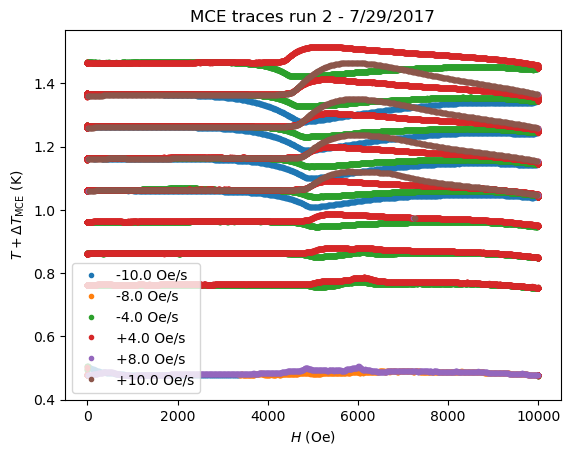

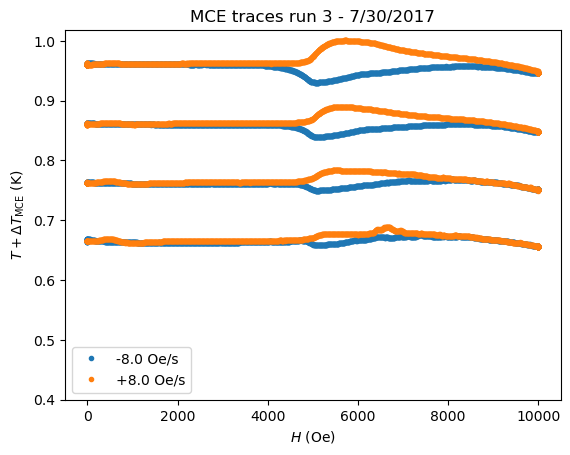

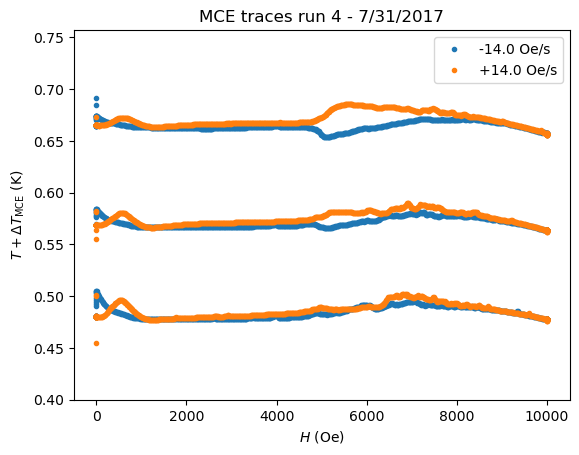

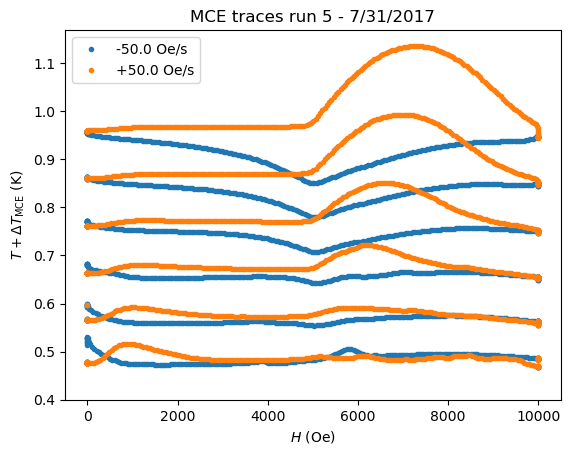

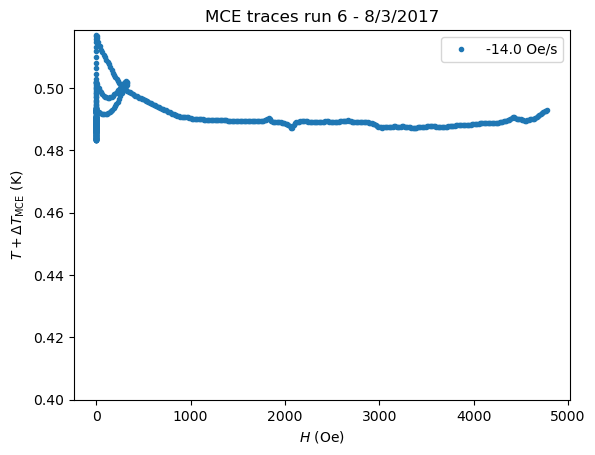

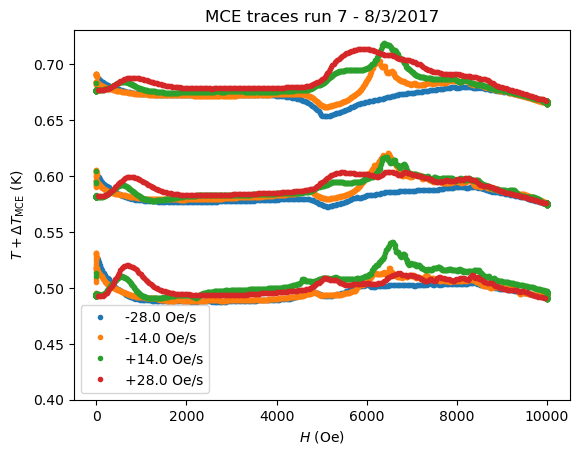

In [234]:
# import ipywidgets as widgets
%matplotlib inline
for runID in runIDs:
    fig = plt.figure()
    for i, sr in enumerate(H[runID].columns):
        plt.plot(H[runID][sr], T[runID][sr], '.', label=f'{sr:+.1f} Oe/s')
    plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(title_mce)
    plt.legend()

In [216]:
sys.path.append(r'C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts')
import MCE_simulations.mce_no_demag as mce
# mce = reload(mce)# if mce is changed

In [373]:
# Identify values of bath temperature used for the measurements
npoints = 250
for runID in runIDs:
    # ut, ct = np.unique(np.round(Tpucki[runID]['raw'], 2), return_counts=True)# Use raw data
    ut, ct = np.unique(np.round(Tpuck[runID], 1), return_counts=True)# Same, by construction of Tpuck[runID]

    # Show counts for each value of bath temperature, ignoring NaN
    print(runID, [[ut[ct>npoints][i], ct[ct>npoints][i]] for i in range(len(ut[ct>npoints]))])
    utbath[runID] = ut[ct>npoints]# select only those values that occur in more than 500 data points
utbath[runID]#

2 [[0.4, 2393], [0.7, 5087], [0.8, 5086], [0.9, 5079], [1.0, 7177], [1.1, 7178], [1.2, 7175], [1.3, 7177], [1.4, 5086]]
3 [[0.6, 2588], [0.7, 2589], [0.8, 2589], [0.9, 2588]]
4 [[0.4, 1518], [0.5, 1523], [0.6, 1523]]
5 [[0.4, 476], [0.5, 499], [0.6, 492], [0.7, 494], [0.8, 490], [0.9, 491]]
6 [[0.4, 752]]
7 [[0.4, 2315], [0.5, 2327], [0.6, 2324]]


array([0.4, 0.5, 0.6])

In [229]:
# Compute bath temperature
def bath_temp(list_of_arrays, rel_temp_var=2.5e-6, rel_temp_bound=1e-3, timeit=False):
    """
    list_of_arrays should be a list of arrays that must include at least a temperature array as its first element
    """
    tic = time.perf_counter()
    T = list_of_arrays[0]
    if len(T)<100:
        warn("Temperature array does not have enough values.")
        return # stop the function
    dT = np.diff(T)
    d = {}
    for idx, elmt in enumerate(list_of_arrays):
        d[idx] = {}
        d[idx]['m'] = np.mean([elmt[1:], elmt[:-1]], 0)
        d[idx]['b'] = d[idx]['m'][abs(dT/d[0]['m'])<rel_temp_var]
        if len(d[idx]['b'])==0:
            raise Exception("Temperature derivative parameter value is too constraining.")
        d[idx]['bm'] = np.mean(d[idx]['b'])
        d[idx]['bath'] = d[idx]['b'][abs(d[idx]['b']-d[idx]['bm'])/d[idx]['bm']<rel_temp_bound]
        while len(d[idx]['bath'])==0:
            rel_temp_bound = rel_temp_bound + 1e-3
            d[idx]['bath'] = d[idx]['b'][abs(d[idx]['b']-d[idx]['bm'])/d[idx]['bm']<rel_temp_bound]
        return_label = 'bath'
    toc = time.perf_counter()
    if timeit is True:
        print(f'Runtime of bath_temp function: {toc - tic:0.4f} seconds')
#     return [d[i][return_label] for i in range(len(d))]# For test purposes
    return np.mean(d[0][return_label])

In [230]:
# Test bat_temp function
sr = sweeprates[runID][0]
for Tb in utbath[runID][:1]:
    dataFilter = np.logical_and(np.logical_and(H[runID][sr]>10, H[runID][sr]<4e3),
                                np.round(Tpuck[runID][sr], 1)==Tb)
    # print(min(dTp), max(dTp))
    Hp = H[runID][sr][dataFilter]
    Tp = T[runID][sr][dataFilter]
    Tb = bath_temp([Tp], rel_temp_bound=1e-3, timeit=True)
    print(Tb)

Runtime of bath_temp function: 0.0006 seconds
0.4879706007700822


In [374]:
##### import ipywidgets as widgets
%matplotlib 
runID = 5
if runID not in mce_fit.keys():
    mce_fit[runID] = {}

dirname = [s for s in next(os.walk('.'))[1] if f'Run{runID}' in s][0]
fitRange = {2:[4e3, 7e3], 3:[4e3, 7e3], 4:[4e3, 6e3], 5:[4e3, 7e3], 7:[4e3, 7e3]}

for us in usr[runID][:]:
    lgd_labels = []
    plt.figure(num=int(us))
    srpm = sweeprates[runID][abs(sweeprates[runID])==us]
    for idx, sr in enumerate(srpm):#sweeprates[2][abs(sweeprates[2])==us[2][0]]:
        for Tb in utbath[runID][:]:
            # select data to analyze; note: solve_ivp fails for H<1 Oe (H/Hc0<2e-3)
            dataFilter = np.logical_and(np.logical_and(H[runID][sr]>10, H[runID][sr]<9.99e3),
                                        np.round(Tpuck[runID][sr], 1)==Tb)
            Hf = H[runID][sr][dataFilter]
            Tf = T[runID][sr][dataFilter]
            if len(Tf)<100: continue
            Tbath = bath_temp([Tf[Hf<4e3]])
            if Tbath is None: continue
            prms = mce.mce_parameters(sweeprate=sr, Tbath=Tbath)
            Hc0 = prms['Hc0'].value
            Tc0 = prms['Tc0'].value
            if sr>0: trace_str = 'upsweep'
            else: trace_str = 'downsweep'
        #     mce_sim[s] = pd.DataFrame(mce.mce_residual(prms, Hf, data=Tf, trace=trace_str))

            Hffit = np.logical_and(Hf>fitRange[runID][0], Hf<fitRange[runID][1])
            if len(Hffit)<100: continue
            out = minimize(mce.mce_residual, prms, args=(Hf[Hffit],),
                           kws={'data':Tf[Hffit], 'trace':trace_str})#, **{'ftol':1e-16})
            mce_fit[runID][sr] = out
        # #     out = minimize(mce.mce_residual, prms, args=(Hf,))
            mce_sim[sr] = mce.mce_residual(out.params, Hf, data=None, trace=trace_str)
            srlabel = f'{sr:+.0f} Oe/s'

            # Plot results
            plt.plot(Hf, Tf, '.', color=f'C{idx}', markersize=2,
                     label=f'data {srlabel}' if srlabel not in lgd_labels else '_nolegend_')
        #     plt.plot(Hf, mce_sim[sr], '-', color=f'C{idx}', label=f'fit {sr:+.1f} Oe/s')
            # Plotting the fit with sorted arguments avoids lines connecting low and high Hf values
            plt.plot(Hf.sort_values(), mce_sim[sr][Hf.argsort()], '-', linewidth=1, color=f'C{idx}',
                     label=f'fit {srlabel}' if srlabel not in lgd_labels else '_nolegend_')
            # Keep track of legend labels to avoid duplicates
            if srlabel not in lgd_labels:
                lgd_labels.append(srlabel)
    plt.title(title_mce)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.legend(loc='upper left')
    
    # Save figure
    savename = f'{dirname}//{this_month}_MCE_fitting//\
{str(today)}_run{runID}_sweeprate+-{us}Oeps_+fits_noMFD.png'
#     plt.savefig(savename, dpi=300)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Temperature array does not have enough values.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Temperature array does not have enough values.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Temperature array does not have enough values.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Temperature array does not have enough values.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Temperature array does not have enough values.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Temperature array does not have enough values.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launc

Using matplotlib backend: Qt5Agg


In [364]:
savename
plt.savefig(savename, dpi=300)